<a href="https://colab.research.google.com/github/M-kaur07/Hardware_Trojan_Detection_GNN/blob/main/GNN_HT_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyverilog networkx
!apt-get install -y iverilog


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.4/136.4 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyverilog: filename=pyverilog-1.3.0-py3-none-any.whl size=118929 sha256=64bcf019cd4b6e6437e93d91216b3d3ba957a86eed3eda168a9dc70ea28b06e6
  Stored in directory: /root/.cache/pip/wheels/e8/ba/6a/1068516e0581249663c83d9c7773bac1c20a8b35e6692dbf02
Successfully built pyverilog
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  gtkwave
The following NEW packages will be installed:
  iverilog
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 2,130 kB of archives.
After this operation, 6,749 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 iverilog amd64 11.0-1.1 [2,130 kB]
Fetched 2,130 kB in 1s (2,004 kB/s)
Selecting previously unselected package iverilog.
(Reading database ... 126281 files and directories c

In [ ]:
from pyverilog.vparser.parser import parse
from collections import defaultdict

def parse_verilog(filepath):
    print(f"Parsing: {filepath}")
    ast, _ = parse([filepath])

    gate_instances = []  # List of (gate_name, gate_type, port_connections)
    wire_to_gates = defaultdict(list)  # net -> [destination gates]

    def visit(node):
        if hasattr(node, 'children'):
            for child in node.children():
                visit(child)
        if node.__class__.__name__ == 'InstanceList':
            for inst in node.instances:
                gate_name = inst.name
                gate_type = inst.module
                conns = {}
                for port in inst.portlist:
                    try:
                        conns[port.portname] = port.argname.name
                    except:
                        conns[port.portname] = str(port.argname)
                gate_instances.append((gate_name, gate_type, conns))

                if 'Y' in conns:
                    for pname, net in conns.items():
                        if pname != 'Y':
                            wire_to_gates[net].append(gate_name)

    visit(ast)
    return gate_instances, wire_to_gates


In [ ]:
file_path = "/content/drive/MyDrive/release_all2/trojan/design3.v"

gates, connections = parse_verilog(file_path)

print("--- Sample Gates ---")
for g in gates[:5]:
    print(g)

print("\n--- Sample Connections ---")
for net, dests in list(connections.items())[:5]:
    print(f"{net} → {dests}")


Parsing: /content/drive/MyDrive/release_all2/trojan/design3.v


Generating LALR tables


--- Sample Gates ---
('g0', 'nand', {None: 'n362'})
('g1', 'dff', {'RN': "1'b1", 'SN': "1'b1", 'CK': 'n0', 'D': 'n999', 'Q': '<pyverilog.vparser.ast.Pointer object at 0x7f21d1f36590>'})
('g2', 'xnor', {None: 'n1199'})
('g3', 'dff', {'RN': "1'b1", 'SN': "1'b1", 'CK': 'n0', 'D': 'n930', 'Q': '<pyverilog.vparser.ast.Pointer object at 0x7f21d1f68e50>'})
('g4', 'nand', {None: 'n353'})

--- Sample Connections ---


In [ ]:
def build_gate_graph_robust(gate_instances):
    import networkx as nx
    from collections import defaultdict

    G = nx.DiGraph()

    # Step 1: Build net→source_gate map and net→dest_gates map
    net_to_drivers = defaultdict(list)
    net_to_loads = defaultdict(list)

    for gate_name, gate_type, conns in gate_instances:
        G.add_node(gate_name, gate_type=gate_type)

        for port_name, net in conns.items():
            if isinstance(net, str) and net.startswith('n'):
                # Heuristic: if port looks like output
                if port_name in ['Y', 'Q', 'ZN', None]:
                    net_to_drivers[net].append(gate_name)
                else:
                    net_to_loads[net].append(gate_name)

    # Step 2: Add edges from drivers → loads via nets
    for net in net_to_drivers:
        for src in net_to_drivers[net]:
            for dst in net_to_loads.get(net, []):
                if src != dst:
                    G.add_edge(src, dst)

    return G


In [ ]:
G = build_gate_graph_robust(gates)

print(f"\nGraph built with {G.number_of_nodes()} gates and {G.number_of_edges()} connections.")

# Show sample edges
for u, v in list(G.edges())[:10]:
    print(f"{u} → {v}")



Graph built with 1479 gates and 0 connections.


In [ ]:
# Print a few full gate connection dictionaries
print("\n--- Full Raw Connections ---")
for g in gates[:50]:
    print(g[2])  # g[2] is the 'conns' dictionary



--- Full Raw Connections ---
{None: 'n362'}
{'RN': "1'b1", 'SN': "1'b1", 'CK': 'n0', 'D': 'n999', 'Q': '<pyverilog.vparser.ast.Pointer object at 0x7f21d1f36590>'}
{None: 'n1199'}
{'RN': "1'b1", 'SN': "1'b1", 'CK': 'n0', 'D': 'n930', 'Q': '<pyverilog.vparser.ast.Pointer object at 0x7f21d1f68e50>'}
{None: 'n353'}
{None: 'n354'}
{None: '<pyverilog.vparser.ast.Pointer object at 0x7f21d1f6b050>'}
{None: 'n153'}
{None: 'n648'}
{None: 'n95'}
{None: 'n639'}
{None: 'n945'}
{None: 'n669'}
{None: 'n378'}
{None: 'n904'}
{None: 'n621'}
{None: 'n518'}
{None: '<pyverilog.vparser.ast.Pointer object at 0x7f21d1f013d0>'}
{None: 'n182'}
{None: 'n897'}
{None: 'n188'}
{None: 'n351'}
{None: '<pyverilog.vparser.ast.Pointer object at 0x7f21d1f04c10>'}
{'RN': "1'b1", 'SN': "1'b1", 'CK': 'n0', 'D': 'n1003', 'Q': '<pyverilog.vparser.ast.Pointer object at 0x7f21d1f064d0>'}
{'RN': "1'b1", 'SN': "1'b1", 'CK': 'n0', 'D': 'n704', 'Q': '<pyverilog.vparser.ast.Pointer object at 0x7f21d1f0b8d0>'}
{None: 'n379'}
{'RN': 

In [ ]:
def build_gate_graph_fixed(gate_instances):
    import networkx as nx
    from collections import defaultdict

    G = nx.DiGraph()
    net_to_sources = defaultdict(list)
    net_to_destinations = defaultdict(list)

    for gate_name, gate_type, conns in gate_instances:
        G.add_node(gate_name, gate_type=gate_type)

        for port_name, net in conns.items():
            # Skip Pointer objects (Q outputs in DFFs)
            if "pyverilog.vparser.ast.Pointer" in str(type(net)):
                continue

            # Net should be a string and look like 'nXXX'
            if not isinstance(net, str) or not net.startswith('n'):
                continue

            # Heuristic: treat port_name == None or port_name in output_names as OUTPUT
            if port_name in ['Y', 'ZN', 'Q', None]:
                net_to_sources[net].append(gate_name)
            else:
                net_to_destinations[net].append(gate_name)

    # Add edges from each source gate to each destination gate sharing a net
    for net in net_to_sources:
        for src in net_to_sources[net]:
            for dst in net_to_destinations.get(net, []):
                if src != dst:
                    G.add_edge(src, dst)

    return G


In [ ]:
G = build_gate_graph_fixed(gates)

print(f"\n✅ Graph built with {G.number_of_nodes()} gates and {G.number_of_edges()} connections.")
print("\n--- Sample Edges ---")
for u, v in list(G.edges())[:10]:
    print(f"{u} → {v}")



✅ Graph built with 1479 gates and 0 connections.

--- Sample Edges ---


In [ ]:
import networkx as nx
from collections import defaultdict

def build_graph_from_labeled_ports(gate_instances):
    G = nx.DiGraph()

    net_to_sources = defaultdict(list)   # net → gate that drives it
    net_to_destinations = defaultdict(list)  # net → gates that use it

    for gate_name, gate_type, conns in gate_instances:
        G.add_node(gate_name, gate_type=gate_type)

        for port_name, net in conns.items():
            # Skip invalid net types (e.g., pointers)
            if "pyverilog.vparser.ast.Pointer" in str(type(net)):
                continue
            if not isinstance(net, str):
                continue

            # Based on port name, decide if it's output or input
            if port_name in ['ZN', 'Z', 'Q', 'Y']:  # commonly used output ports
                net_to_sources[net].append(gate_name)
            else:  # input ports
                net_to_destinations[net].append(gate_name)

    # Add edges: from source gate → destination gate via shared net
    for net in net_to_sources:
        for src in net_to_sources[net]:
            for dst in net_to_destinations.get(net, []):
                if src != dst:
                    G.add_edge(src, dst, via=net)

    return G


In [ ]:
gates, connections = parse_verilog("/content/drive/MyDrive/release_all2/trojan/design0.v")


Parsing: /content/drive/MyDrive/release_all2/trojan/design0.v


Generating LALR tables


In [ ]:
G = build_graph_from_labeled_ports(gates)

print(f"✅ Graph has {G.number_of_nodes()} gates and {G.number_of_edges()} connections.")

# Show some connections
for u, v, data in list(G.edges(data=True))[:10]:
    print(f"{u} → {v} via net {data['via']}")


✅ Graph has 3041 gates and 2 connections.
g560 → g394 via net n2040
g1145 → g1580 via net n2039


In [ ]:
def build_graph_with_better_output_guessing(gate_instances):
    import networkx as nx
    from collections import defaultdict

    G = nx.DiGraph()
    net_to_sources = defaultdict(list)
    net_to_destinations = defaultdict(list)

    for gate_name, gate_type, conns in gate_instances:
        G.add_node(gate_name, gate_type=gate_type)

        for port_name, net in conns.items():
            if "pyverilog.vparser.ast.Pointer" in str(type(net)) or not isinstance(net, str):
                continue

            # Heuristic: treat ports with Z*/Q*/Y*/ZN/None as outputs
            if port_name is None or \
               port_name.startswith('Z') or \
               port_name.startswith('Q') or \
               port_name in ['Y', 'ZN', 'Z']:
                net_to_sources[net].append(gate_name)
            else:
                net_to_destinations[net].append(gate_name)

    for net in net_to_sources:
        for src in net_to_sources[net]:
            for dst in net_to_destinations.get(net, []):
                if src != dst:
                    G.add_edge(src, dst, via=net)

    return G


In [ ]:
G = build_graph_with_better_output_guessing(gates)

print(f"✅ Graph has {G.number_of_nodes()} gates and {G.number_of_edges()} connections.")

for u, v, data in list(G.edges(data=True))[:10]:
    print(f"{u} → {v} via net {data['via']}")


✅ Graph has 3041 gates and 1 connections.
g366 → g3022 via net n381


In [ ]:
def build_graph_by_position(gate_instances):
    import networkx as nx
    from collections import defaultdict

    G = nx.DiGraph()
    net_to_sources = defaultdict(list)
    net_to_destinations = defaultdict(list)

    for gate_name, gate_type, conns in gate_instances:
        G.add_node(gate_name, gate_type=gate_type)

        port_items = list(conns.items())
        clean_ports = []

        # Filter out invalid nets
        for pname, net in port_items:
            if "pyverilog.vparser.ast.Pointer" in str(type(net)) or not isinstance(net, str):
                continue
            clean_ports.append((pname, net))

        if not clean_ports:
            continue

        # Output = last net
        *inputs, (output_port, output_net) = clean_ports

        net_to_sources[output_net].append(gate_name)

        for _, input_net in inputs:
            net_to_destinations[input_net].append(gate_name)

    # Connect source gates → destination gates via shared net
    for net in net_to_sources:
        for src in net_to_sources[net]:
            for dst in net_to_destinations.get(net, []):
                if src != dst:
                    G.add_edge(src, dst, via=net)

    return G


In [ ]:
gates, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan/design1.v")
G = build_graph_by_position(gates)

print(f"✅ Graph has {G.number_of_nodes()} gates and {G.number_of_edges()} connections.")

# Sample edges
for u, v, data in list(G.edges(data=True))[:10]:
    print(f"{u} → {v} via net {data['via']}")


Parsing: /content/drive/MyDrive/release_all2/trojan/design1.v


Generating LALR tables


✅ Graph has 1660 gates and 57 connections.
g51 → g713 via net n1605
g141 → g713 via net n1605
g670 → g12 via net n1
g670 → g27 via net n1
g670 → g51 via net n1
g670 → g117 via net n1
g670 → g154 via net n1
g670 → g200 via net n1
g670 → g236 via net n1
g670 → g239 via net n1


In [ ]:
aes_gates, aes_conns = parse_verilog("/content/drive/MyDrive/AES-T2200/AES-T2200/src/TjIn/aes_synth.v")


Parsing: /content/drive/MyDrive/AES-T2200/AES-T2200/src/TjIn/aes_synth.v


Generating LALR tables


In [ ]:
G = build_graph_by_position(aes_gates)
print(f"✅ Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")


In [ ]:
print(f"Total gates parsed: {len(aes_gates)}")


Total gates parsed: 142285


In [ ]:
print(f"Gates (nodes): {G.number_of_nodes()}, Edges (connections): {G.number_of_edges()}")


Gates (nodes): 1191, Edges (connections): 8872


In [ ]:
def build_graph_debug(gate_instances):
    import networkx as nx
    from collections import defaultdict

    G = nx.DiGraph()
    net_to_sources = defaultdict(list)
    net_to_destinations = defaultdict(list)

    total_gates = 0
    skipped_gates = 0
    added_nodes = 0

    for gate_name, gate_type, conns in gate_instances:
        total_gates += 1
        port_items = list(conns.items())
        clean_ports = []

        for pname, net in port_items:
            if "pyverilog.vparser.ast.Pointer" in str(type(net)) or not isinstance(net, str):
                continue
            clean_ports.append((pname, net))

        if not clean_ports or len(clean_ports) < 2:
            skipped_gates += 1
            continue

        # Output = last net
        *inputs, (output_port, output_net) = clean_ports

        G.add_node(gate_name, gate_type=gate_type)
        added_nodes += 1

        net_to_sources[output_net].append(gate_name)
        for _, input_net in inputs:
            net_to_destinations[input_net].append(gate_name)

    for net in net_to_sources:
        for src in net_to_sources[net]:
            for dst in net_to_destinations.get(net, []):
                if src != dst:
                    G.add_edge(src, dst, via=net)

    print(f"🔢 Total gates processed: {total_gates}")
    print(f"✅ Gates added to graph: {added_nodes}")
    print(f"⚠️ Skipped gates (invalid or pointer): {skipped_gates}")
    print(f"📈 Final graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

    return G


In [ ]:
G = build_graph_debug(aes_gates)


🔢 Total gates processed: 142285
✅ Gates added to graph: 142285
⚠️ Skipped gates (invalid or pointer): 0
📈 Final graph: 1191 nodes, 8872 edges


In [ ]:
# Subgraph detection (for directed graphs, use weakly connected components)
subgraphs = list(nx.weakly_connected_components(G))
print(f"🔎 Found {len(subgraphs)} disconnected subgraphs.")

# Sort by size (largest first)
subgraphs = sorted(subgraphs, key=len, reverse=True)

# Optionally print top 3 subgraph sizes
print("Top 3 subgraph sizes:")
for i in range(min(10, len(subgraphs))):
    print(f"Subgraph {i+1}: {len(subgraphs[i])} nodes")


🔎 Found 538 disconnected subgraphs.
Top 3 subgraph sizes:
Subgraph 1: 654 nodes
Subgraph 2: 1 nodes
Subgraph 3: 1 nodes
Subgraph 4: 1 nodes
Subgraph 5: 1 nodes
Subgraph 6: 1 nodes
Subgraph 7: 1 nodes
Subgraph 8: 1 nodes
Subgraph 9: 1 nodes
Subgraph 10: 1 nodes


In [ ]:
import pandas as pd

def extract_node_features(G):
    features = []

    for node in G.nodes:
        gate_type = G.nodes[node].get('gate_type', 'UNKNOWN')
        fanin = G.in_degree(node)
        fanout = G.out_degree(node)
        features.append({
            'node': node,
            'gate_type': gate_type,
            'fanin': fanin,
            'fanout': fanout
        })

    return pd.DataFrame(features)


In [ ]:
features_df = extract_node_features(G)
print("✅ Features extracted:")
print(features_df.head())


✅ Features extracted:
          node gate_type  fanin  fanout
0  \out_reg[7]     DFFX1      1       0
1  \out_reg[6]     DFFX1      1       0
2  \out_reg[5]     DFFX1      2       0
3  \out_reg[4]     DFFX1      2       0
4  \out_reg[3]     DFFX1      2       0


In [ ]:
# Keep largest subgraph (subgraphs is already sorted)
main_nodes = subgraphs[0]

# Extract it from the full graph
G_main = G.subgraph(main_nodes).copy()

print(f"📦 Largest connected subgraph extracted: {G_main.number_of_nodes()} nodes, {G_main.number_of_edges()} edges")


📦 Largest connected subgraph extracted: 654 nodes, 8872 edges


In [ ]:
!pip install pyvis


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.1 MB/s eta 0:00:00


In [ ]:
G_main = G.subgraph(subgraphs[0]).copy()


In [ ]:
from pyvis.network import Network

def visualize_graph_pyvis(G, output_file="aes_subgraph.html"):
    net = Network(height="750px", width="100%", directed=True, notebook=False)

    for node in G.nodes:
        gate_type = G.nodes[node].get('gate_type', 'UNKNOWN')
        label = f"{node}\n({gate_type})"
        net.add_node(node, label=label, title=label)

    for src, dst, data in G.edges(data=True):
        net_label = data.get('via', '')
        net.add_edge(src, dst, title=net_label)

    net.repulsion(node_distance=120, spring_length=200)
    net.save_graph(output_file)
    return output_file


In [ ]:
# Generate visualization
file_path = "aes_subgraph.html"
visualize_graph_pyvis(G_main, file_path)

# Download the file
from google.colab import files
files.download(file_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from pyvis.network import Network

def visualize_light_graph(G, output_file="aes_subgraph_light.html", max_nodes=654):
    net = Network(height="750px", width="100%", directed=True, notebook=False)
    net.barnes_hut()  # faster layout than force-directed

    node_count = 0
    for node in G.nodes:
        if node_count >= max_nodes:
            break
        gate_type = G.nodes[node].get('gate_type', 'UNKNOWN')
        label = gate_type
        net.add_node(node, label=label, title=f"{node}", shape='dot', size=10)
        node_count += 1

    edge_count = 0
    for src, dst in G.edges():
        net.add_edge(src, dst)

    net.save_graph(output_file)
    return output_file


In [ ]:
# Visualize the simplified version
file_path = "aes_subgraph_light.html"
visualize_light_graph(G_main, file_path)

# Download for interactive viewing
from google.colab import files
files.download(file_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Visualize the largest connected subgraph statically
def draw_static_subgraph(G, num_nodes=100):
    sub_nodes = list(G.nodes)[:num_nodes]  # select first N nodes
    H = G.subgraph(sub_nodes)

    pos = nx.spring_layout(H, seed=42)  # layout for small graphs
    plt.figure(figsize=(12, 12))
    nx.draw_networkx_nodes(H, pos, node_size=50, node_color='skyblue')
    nx.draw_networkx_edges(H, pos, arrows=True, width=0.3)
    nx.draw_networkx_labels(H, pos, font_size=6)
    plt.axis('off')
    plt.title(f"Sample Subgraph ({num_nodes} nodes)")
    plt.show()


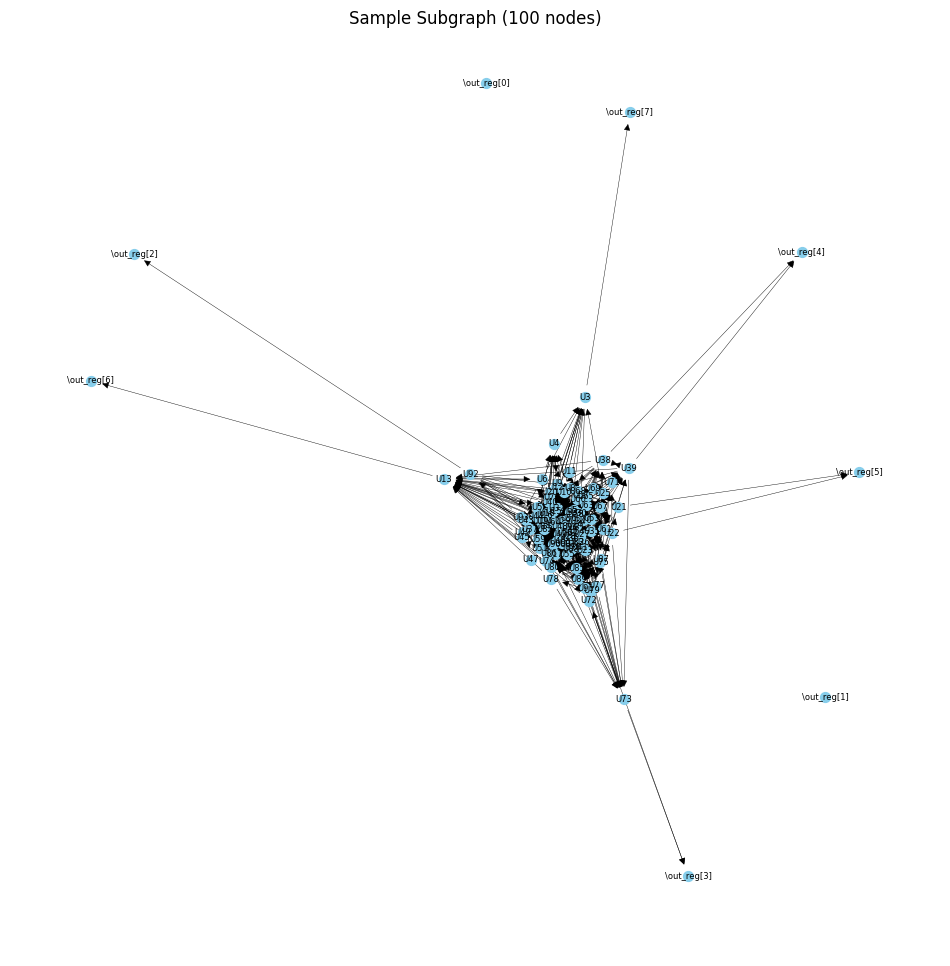

In [ ]:
draw_static_subgraph(G_main, num_nodes=100)


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

def draw_static_subgraph(G, num_nodes=100):
    # Select the first N nodes from the subgraph
    sub_nodes = list(G.nodes)[:num_nodes]
    H = G.subgraph(sub_nodes)

    # Use a spring layout for spacing
    pos = nx.spring_layout(H, seed=42)

    # Draw the graph
    plt.figure(figsize=(12, 12))
    nx.draw_networkx_nodes(H, pos, node_size=60, node_color='skyblue')
    nx.draw_networkx_edges(H, pos, arrows=True, width=0.3, edge_color='gray')
    nx.draw_networkx_labels(H, pos, font_size=6)
    plt.title(f"Sample AES Subgraph Visualization ({num_nodes} nodes)", fontsize=14)
    plt.axis('off')
    plt.show()


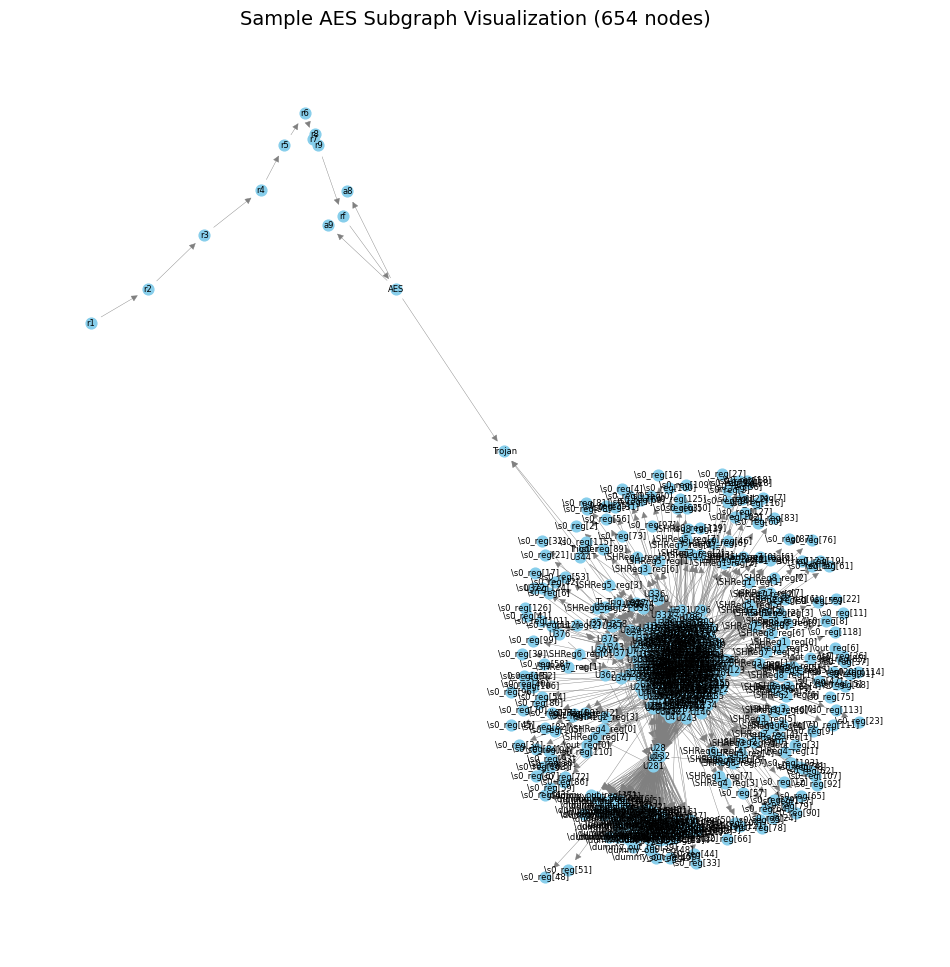

In [ ]:
draw_static_subgraph(G_main, num_nodes=654)


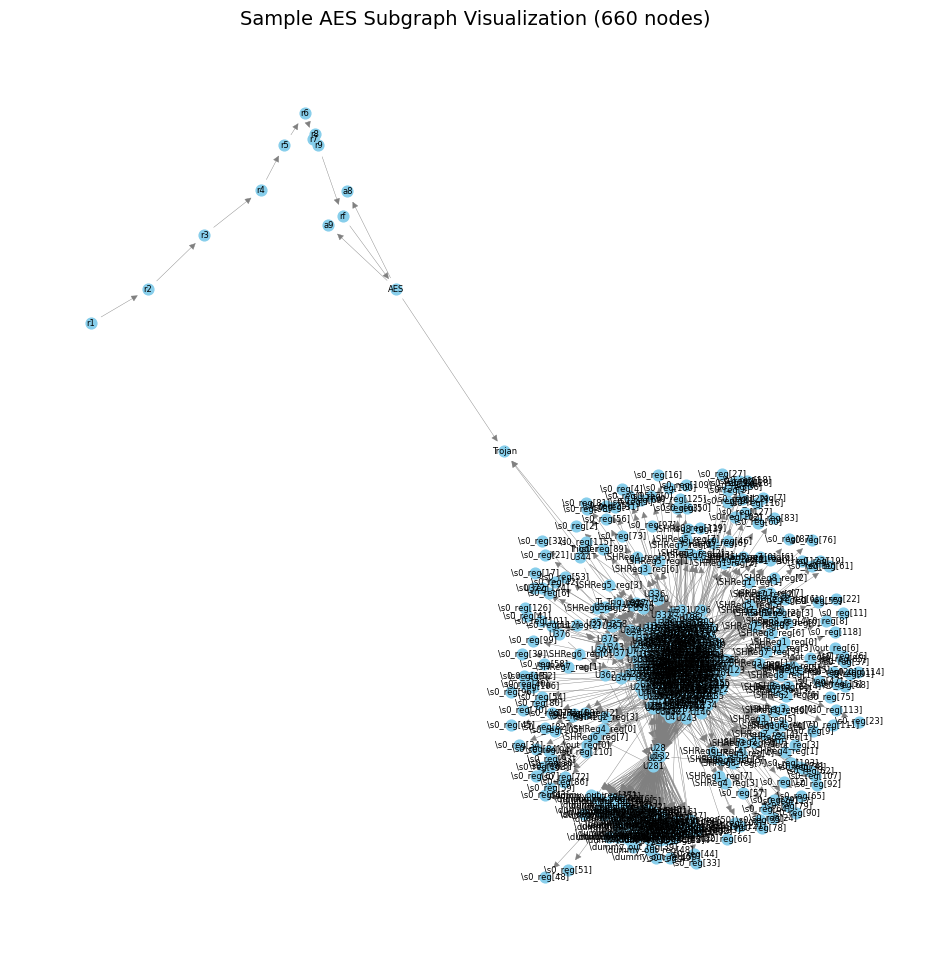

In [ ]:
draw_static_subgraph(G_main, num_nodes=660)


In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

def encode_gate_types(G):
    gate_types = [G.nodes[node].get('gate_type', 'UNKNOWN') for node in G.nodes]
    node_list = list(G.nodes)

    encoder = OneHotEncoder(sparse_output=False)  # <-- Fixed here
    type_features = encoder.fit_transform(pd.DataFrame(gate_types))

    features_dict = {
        node: type_features[i] for i, node in enumerate(node_list)
    }

    return features_dict, encoder.get_feature_names_out()


In [ ]:
node_features, feature_names = encode_gate_types(G_main)
print(f"🔢 Gate type features shape: {len(node_features)} nodes × {len(feature_names)} features")


🔢 Gate type features shape: 654 nodes × 39 features


In [ ]:
# Safe install for Colab + Torch 2.x
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.1.0+cpu.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cpu.html
!pip install torch-geometric


Looking in links: https://data.pyg.org/whl/torch-2.1.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.4/500.4 kB 6.7 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 1.9 MB/s eta 0:00:00


In [ ]:
import torch
from torch_geometric.data import Data

def convert_to_pyg(G, node_features_dict):
    # Map node names to indices
    node_list = list(G.nodes)
    node_index_map = {node: i for i, node in enumerate(node_list)}

    # Convert features
    #x = torch.tensor([node_features_dict[node] for node in node_list], dtype=torch.float)
    x = torch.tensor(np.array([node_features_dict[node] for node in node_list]), dtype=torch.float)

    # Convert edges to index format
    edge_index = []
    for src, dst in G.edges():
        if src in node_index_map and dst in node_index_map:
            edge_index.append([node_index_map[src], node_index_map[dst]])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # Dummy labels (optional)
    y = torch.zeros(x.size(0), dtype=torch.long)

    data = Data(x=x, edge_index=edge_index, y=y)
    return data


/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [ ]:
import numpy as np
pyg_data = convert_to_pyg(G_main, node_features)
print(pyg_data)


Data(x=[654, 39], edge_index=[2, 8872], y=[654])


In [ ]:
import torch
print(torch.__version__)


2.6.0+cu124


In [ ]:
gates, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan/design1.v")
G = build_graph_by_position(gates)

print(f"✅ Graph has {G.number_of_nodes()} gates and {G.number_of_edges()} connections.")

# Sample edges
for u, v, data in list(G.edges(data=True))[:10]:
    print(f"{u} → {v} via net {data['via']}")


Parsing: /content/drive/MyDrive/release_all2/trojan/design1.v


Generating LALR tables


✅ Graph has 1660 gates and 57 connections.
g51 → g713 via net n1605
g141 → g713 via net n1605
g670 → g12 via net n1
g670 → g27 via net n1
g670 → g51 via net n1
g670 → g117 via net n1
g670 → g154 via net n1
g670 → g200 via net n1
g670 → g236 via net n1
g670 → g239 via net n1


In [ ]:
gates, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan/design0.v")
G = build_graph_by_position(gates)

print(f"✅ Graph has {G.number_of_nodes()} gates and {G.number_of_edges()} connections.")

# Sample edges
for u, v, data in list(G.edges(data=True))[:10]:
    print(f"{u} → {v} via net {data['via']}")


Parsing: /content/drive/MyDrive/release_all2/trojan/design0.v


Generating LALR tables


✅ Graph has 3041 gates and 1 connections.
g366 → g3022 via net n381


In [ ]:
gates, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan/design2.v")
G = build_graph_by_position(gates)

print(f"✅ Graph has {G.number_of_nodes()} gates and {G.number_of_edges()} connections.")

# Sample edges
for u, v, data in list(G.edges(data=True))[:10]:
    print(f"{u} → {v} via net {data['via']}")


Parsing: /content/drive/MyDrive/release_all2/trojan/design2.v


Generating LALR tables


✅ Graph has 325 gates and 0 connections.


In [ ]:
gates, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan/design3.v")
G = build_graph_by_position(gates)

print(f"✅ Graph has {G.number_of_nodes()} gates and {G.number_of_edges()} connections.")

# Sample edges
for u, v, data in list(G.edges(data=True))[:10]:
    print(f"{u} → {v} via net {data['via']}")


Parsing: /content/drive/MyDrive/release_all2/trojan/design3.v


Generating LALR tables


✅ Graph has 1479 gates and 0 connections.


In [ ]:
gates, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan/design4.v")
G = build_graph_by_position(gates)

print(f"✅ Graph has {G.number_of_nodes()} gates and {G.number_of_edges()} connections.")

# Sample edges
for u, v, data in list(G.edges(data=True))[:10]:
    print(f"{u} → {v} via net {data['via']}")


Parsing: /content/drive/MyDrive/release_all2/trojan/design4.v


Generating LALR tables


✅ Graph has 3002 gates and 0 connections.


In [ ]:
gates, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan/design5.v")
G = build_graph_by_position(gates)

print(f"✅ Graph has {G.number_of_nodes()} gates and {G.number_of_edges()} connections.")

# Sample edges
for u, v, data in list(G.edges(data=True))[:10]:
    print(f"{u} → {v} via net {data['via']}")


Parsing: /content/drive/MyDrive/release_all2/trojan/design5.v


Generating LALR tables


✅ Graph has 801 gates and 0 connections.


In [ ]:
gates, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan/design6.v")
G = build_graph_by_position(gates)

print(f"✅ Graph has {G.number_of_nodes()} gates and {G.number_of_edges()} connections.")

# Sample edges
for u, v, data in list(G.edges(data=True))[:10]:
    print(f"{u} → {v} via net {data['via']}")


Parsing: /content/drive/MyDrive/release_all2/trojan/design6.v


Generating LALR tables


✅ Graph has 2683 gates and 0 connections.


In [ ]:
gates, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan/design7.v")
G = build_graph_by_position(gates)

print(f"✅ Graph has {G.number_of_nodes()} gates and {G.number_of_edges()} connections.")

# Sample edges
for u, v, data in list(G.edges(data=True))[:10]:
    print(f"{u} → {v} via net {data['via']}")


Parsing: /content/drive/MyDrive/release_all2/trojan/design7.v


Generating LALR tables


✅ Graph has 2544 gates and 0 connections.


In [ ]:
gates, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan/design8.v")
G = build_graph_by_position(gates)

print(f"✅ Graph has {G.number_of_nodes()} gates and {G.number_of_edges()} connections.")

# Sample edges
for u, v, data in list(G.edges(data=True))[:10]:
    print(f"{u} → {v} via net {data['via']}")


Parsing: /content/drive/MyDrive/release_all2/trojan/design8.v


Generating LALR tables


✅ Graph has 83 gates and 0 connections.


In [ ]:
gates, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan/design9.v")
G = build_graph_by_position(gates)

print(f"✅ Graph has {G.number_of_nodes()} gates and {G.number_of_edges()} connections.")

# Sample edges
for u, v, data in list(G.edges(data=True))[:10]:
    print(f"{u} → {v} via net {data['via']}")


Parsing: /content/drive/MyDrive/release_all2/trojan/design9.v


Generating LALR tables


✅ Graph has 4188 gates and 0 connections.


In [ ]:
gates, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan/design10.v")
G = build_graph_by_position(gates)

print(f"✅ Graph has {G.number_of_nodes()} gates and {G.number_of_edges()} connections.")

# Sample edges
for u, v, data in list(G.edges(data=True))[:10]:
    print(f"{u} → {v} via net {data['via']}")
gates, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan/design11.v")
G = build_graph_by_position(gates)

print(f"✅ Graph has {G.number_of_nodes()} gates and {G.number_of_edges()} connections.")

# Sample edges
for u, v, data in list(G.edges(data=True))[:10]:
    print(f"{u} → {v} via net {data['via']}")
gates, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan/design12.v")
G = build_graph_by_position(gates)

print(f"✅ Graph has {G.number_of_nodes()} gates and {G.number_of_edges()} connections.")

# Sample edges
for u, v, data in list(G.edges(data=True))[:10]:
    print(f"{u} → {v} via net {data['via']}")
gates, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan/design13.v")
G = build_graph_by_position(gates)

print(f"✅ Graph has {G.number_of_nodes()} gates and {G.number_of_edges()} connections.")

# Sample edges
for u, v, data in list(G.edges(data=True))[:10]:
    print(f"{u} → {v} via net {data['via']}")
gates, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan/design14.v")
G = build_graph_by_position(gates)

print(f"✅ Graph has {G.number_of_nodes()} gates and {G.number_of_edges()} connections.")

# Sample edges
for u, v, data in list(G.edges(data=True))[:10]:
    print(f"{u} → {v} via net {data['via']}")
gates, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan/design15.v")
G = build_graph_by_position(gates)

print(f"✅ Graph has {G.number_of_nodes()} gates and {G.number_of_edges()} connections.")

# Sample edges
for u, v, data in list(G.edges(data=True))[:10]:
    print(f"{u} → {v} via net {data['via']}")
gates, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan/design16.v")
G = build_graph_by_position(gates)

print(f"✅ Graph has {G.number_of_nodes()} gates and {G.number_of_edges()} connections.")

# Sample edges
for u, v, data in list(G.edges(data=True))[:10]:
    print(f"{u} → {v} via net {data['via']}")
gates, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan/design17.v")
G = build_graph_by_position(gates)

print(f"✅ Graph has {G.number_of_nodes()} gates and {G.number_of_edges()} connections.")

# Sample edges
for u, v, data in list(G.edges(data=True))[:10]:
    print(f"{u} → {v} via net {data['via']}")
gates, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan/design18.v")
G = build_graph_by_position(gates)

print(f"✅ Graph has {G.number_of_nodes()} gates and {G.number_of_edges()} connections.")

# Sample edges
for u, v, data in list(G.edges(data=True))[:10]:
    print(f"{u} → {v} via net {data['via']}")
gates, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan/design19.v")
G = build_graph_by_position(gates)

print(f"✅ Graph has {G.number_of_nodes()} gates and {G.number_of_edges()} connections.")

# Sample edges
for u, v, data in list(G.edges(data=True))[:10]:
    print(f"{u} → {v} via net {data['via']}")
gates, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan/design1.v")
G = build_graph_by_position(gates)

print(f"✅ Graph has {G.number_of_nodes()} gates and {G.number_of_edges()} connections.")


Parsing: /content/drive/MyDrive/release_all2/trojan/design10.v


Generating LALR tables


✅ Graph has 567 gates and 190 connections.
g66 → g477 via net n398
g84 → g8 via net n1
g84 → g10 via net n1
g84 → g11 via net n1
g84 → g15 via net n1
g84 → g19 via net n1
g84 → g22 via net n1
g84 → g24 via net n1
g84 → g26 via net n1
g84 → g29 via net n1
Parsing: /content/drive/MyDrive/release_all2/trojan/design11.v


Generating LALR tables


✅ Graph has 2166 gates and 0 connections.
Parsing: /content/drive/MyDrive/release_all2/trojan/design12.v


Generating LALR tables


✅ Graph has 448 gates and 0 connections.
Parsing: /content/drive/MyDrive/release_all2/trojan/design13.v


Generating LALR tables


✅ Graph has 579 gates and 6 connections.
g48 → g467 via net n273
g82 → g467 via net n273
g149 → g437 via net n337
g208 → g467 via net n273
g546 → g467 via net n273
g553 → g467 via net n273
Parsing: /content/drive/MyDrive/release_all2/trojan/design14.v


Generating LALR tables


✅ Graph has 6917 gates and 0 connections.
Parsing: /content/drive/MyDrive/release_all2/trojan/design15.v


Generating LALR tables


✅ Graph has 548 gates and 3 connections.
g96 → g511 via net n229
g116 → g511 via net n229
g250 → g511 via net n229
Parsing: /content/drive/MyDrive/release_all2/trojan/design16.v


Generating LALR tables


✅ Graph has 3014 gates and 0 connections.
Parsing: /content/drive/MyDrive/release_all2/trojan/design17.v


Generating LALR tables


✅ Graph has 503 gates and 4 connections.
g44 → g340 via net n268
g65 → g340 via net n268
g224 → g340 via net n268
g449 → g340 via net n268
Parsing: /content/drive/MyDrive/release_all2/trojan/design18.v


Generating LALR tables


✅ Graph has 241 gates and 1 connections.
g79 → g9 via net n145
Parsing: /content/drive/MyDrive/release_all2/trojan/design19.v


Generating LALR tables


✅ Graph has 2458 gates and 0 connections.
Parsing: /content/drive/MyDrive/release_all2/trojan/design1.v


Generating LALR tables


✅ Graph has 1660 gates and 57 connections.


In [ ]:
gates, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan_free/design20.v")
G = build_graph_by_position(gates)

print(f"✅ Graph has {G.number_of_nodes()} gates and {G.number_of_edges()} connections.")

# Sample edges
for u, v, data in list(G.edges(data=True))[:10]:
    print(f"{u} → {v} via net {data['via']}")
gates, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan_free/design21.v")
G = build_graph_by_position(gates)

print(f"✅ Graph has {G.number_of_nodes()} gates and {G.number_of_edges()} connections.")

# Sample edges
for u, v, data in list(G.edges(data=True))[:10]:
    print(f"{u} → {v} via net {data['via']}")
gates, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan_free/design22.v")
G = build_graph_by_position(gates)

print(f"✅ Graph has {G.number_of_nodes()} gates and {G.number_of_edges()} connections.")

# Sample edges
for u, v, data in list(G.edges(data=True))[:10]:
    print(f"{u} → {v} via net {data['via']}")
gates, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan_free/design23.v")
G = build_graph_by_position(gates)

print(f"✅ Graph has {G.number_of_nodes()} gates and {G.number_of_edges()} connections.")

# Sample edges
for u, v, data in list(G.edges(data=True))[:10]:
    print(f"{u} → {v} via net {data['via']}")
gates, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan_free/design24.v")
G = build_graph_by_position(gates)

print(f"✅ Graph has {G.number_of_nodes()} gates and {G.number_of_edges()} connections.")

# Sample edges
for u, v, data in list(G.edges(data=True))[:10]:
    print(f"{u} → {v} via net {data['via']}")
gates, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan_free/design25.v")
G = build_graph_by_position(gates)

print(f"✅ Graph has {G.number_of_nodes()} gates and {G.number_of_edges()} connections.")

# Sample edges
for u, v, data in list(G.edges(data=True))[:10]:
    print(f"{u} → {v} via net {data['via']}")
gates, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan_free/design26.v")
G = build_graph_by_position(gates)

print(f"✅ Graph has {G.number_of_nodes()} gates and {G.number_of_edges()} connections.")

# Sample edges
for u, v, data in list(G.edges(data=True))[:10]:
    print(f"{u} → {v} via net {data['via']}")
gates, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan_free/design27.v")
G = build_graph_by_position(gates)

print(f"✅ Graph has {G.number_of_nodes()} gates and {G.number_of_edges()} connections.")

# Sample edges
for u, v, data in list(G.edges(data=True))[:10]:
    print(f"{u} → {v} via net {data['via']}")
gates, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan_free/design28.v")
G = build_graph_by_position(gates)

print(f"✅ Graph has {G.number_of_nodes()} gates and {G.number_of_edges()} connections.")

# Sample edges
for u, v, data in list(G.edges(data=True))[:10]:
    print(f"{u} → {v} via net {data['via']}")
gates, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan_free/design29.v")
G = build_graph_by_position(gates)

print(f"✅ Graph has {G.number_of_nodes()} gates and {G.number_of_edges()} connections.")

# Sample edges
for u, v, data in list(G.edges(data=True))[:10]:
    print(f"{u} → {v} via net {data['via']}")
gates, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan/design1.v")
G = build_graph_by_position(gates)

print(f"✅ Graph has {G.number_of_nodes()} gates and {G.number_of_edges()} connections.")


Parsing: /content/drive/MyDrive/release_all2/trojan_free/design20.v


Generating LALR tables


✅ Graph has 2808 gates and 0 connections.
Parsing: /content/drive/MyDrive/release_all2/trojan_free/design21.v


Generating LALR tables


✅ Graph has 4058 gates and 1 connections.
g3940 → g2029 via net n829
Parsing: /content/drive/MyDrive/release_all2/trojan_free/design22.v


Generating LALR tables


✅ Graph has 152 gates and 0 connections.
Parsing: /content/drive/MyDrive/release_all2/trojan_free/design23.v


Generating LALR tables


✅ Graph has 2570 gates and 0 connections.
Parsing: /content/drive/MyDrive/release_all2/trojan_free/design24.v


Generating LALR tables


✅ Graph has 489 gates and 0 connections.
Parsing: /content/drive/MyDrive/release_all2/trojan_free/design25.v


Generating LALR tables


✅ Graph has 243 gates and 2 connections.
g114 → g222 via net n125
g167 → g120 via net n196
Parsing: /content/drive/MyDrive/release_all2/trojan_free/design26.v


Generating LALR tables


✅ Graph has 2250 gates and 1 connections.
g2037 → g1601 via net n189
Parsing: /content/drive/MyDrive/release_all2/trojan_free/design27.v


Generating LALR tables


✅ Graph has 2435 gates and 0 connections.
Parsing: /content/drive/MyDrive/release_all2/trojan_free/design28.v


Generating LALR tables


✅ Graph has 7318 gates and 0 connections.
Parsing: /content/drive/MyDrive/release_all2/trojan_free/design29.v


Generating LALR tables


✅ Graph has 2227 gates and 0 connections.
Parsing: /content/drive/MyDrive/release_all2/trojan/design1.v


Generating LALR tables


✅ Graph has 1660 gates and 57 connections.


In [ ]:
# Parse design1.v
gates1, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan/design1.v")
G1 = build_graph_by_position(gates1)
print(f"✅ design1: {G1.number_of_nodes()} nodes, {G1.number_of_edges()} edges")

# Parse design10.v
gates10, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan/design10.v")
G10 = build_graph_by_position(gates10)
print(f"✅ design10: {G10.number_of_nodes()} nodes, {G10.number_of_edges()} edges")


Parsing: /content/drive/MyDrive/release_all2/trojan/design1.v


Generating LALR tables


✅ design1: 1660 nodes, 57 edges
Parsing: /content/drive/MyDrive/release_all2/trojan/design10.v


Generating LALR tables


✅ design10: 567 nodes, 190 edges


In [ ]:
def load_result_file(path):
    with open(path, "r") as f:
        trojan_gates = [line.strip() for line in f if line.strip()]
    return set(trojan_gates)

trojan1 = load_result_file("/content/drive/MyDrive/release_all2/trojan/result1.txt")
trojan10 = load_result_file("/content/drive/MyDrive/release_all2/trojan/result10.txt")

print(f"✅ result1.txt: {len(trojan1)} Trojan gates")
print(f"✅ result10.txt: {len(trojan10)} Trojan gates")


✅ result1.txt: 27 Trojan gates
✅ result10.txt: 28 Trojan gates


In [ ]:
def assign_labels(G, trojan_gates):
    labels = {}
    for node in G.nodes:
        labels[node] = 1 if node in trojan_gates else 0
    return labels


In [ ]:
labels1 = assign_labels(G1, trojan1)
labels10 = assign_labels(G10, trojan10)


In [ ]:
def encode_gate_types(G):
    from sklearn.preprocessing import OneHotEncoder
    import pandas as pd
    gate_types = [G.nodes[n].get('gate_type', 'UNKNOWN') for n in G.nodes]
    node_list = list(G.nodes)

    enc = OneHotEncoder(sparse_output=False)
    type_feats = enc.fit_transform(pd.DataFrame(gate_types))

    features = {node: type_feats[i] for i, node in enumerate(node_list)}
    return features, enc.get_feature_names_out()


In [ ]:
features1, feature_names1 = encode_gate_types(G1)
features10, feature_names10 = encode_gate_types(G10)


In [ ]:
from torch_geometric.data import Data
import torch
import numpy as np

def to_pyg_data(G, node_features, labels):
    node_list = list(G.nodes)
    idx_map = {n: i for i, n in enumerate(node_list)}

    # Features
    x = torch.tensor(np.array([node_features[n] for n in node_list]), dtype=torch.float)

    # Edges
    edges = [[idx_map[u], idx_map[v]] for u, v in G.edges if u in idx_map and v in idx_map]
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    # Labels
    y = torch.tensor([labels[n] for n in node_list], dtype=torch.long)

    return Data(x=x, edge_index=edge_index, y=y)


In [ ]:
data1 = to_pyg_data(G1, features1, labels1)
data10 = to_pyg_data(G10, features10, labels10)


In [ ]:
print(data1)   # For design1.v
print(data10)  # For design10.v


Data(x=[1660, 8], edge_index=[2, 57], y=[1660])
Data(x=[567, 8], edge_index=[2, 190], y=[567])


In [ ]:
set([G1.nodes[n]['gate_type'] for n in G1.nodes])


{'buf', 'dff', 'nand', 'nor', 'not', 'or', 'xnor', 'xor'}

In [ ]:
set([G10.nodes[n]['gate_type'] for n in G10.nodes])


{'buf', 'dff', 'nand', 'nor', 'not', 'or', 'xnor', 'xor'}

In [ ]:
def extract_wires(ast):
    from pyverilog.vparser.ast import Decl, Wire
    wires = set()

    def walk(node):
        if isinstance(node, Decl):
            for decl in node.list:
                if isinstance(decl, Wire):
                    # FIX: handle both .name and .names
                    if hasattr(decl, 'names'):
                        for n in decl.names:
                            wires.add(n.name)
                    elif hasattr(decl, 'name'):
                        wires.add(decl.name)
        for child in node.children():
            walk(child)

    walk(ast)
    return wires


In [ ]:
def extract_gate_io(gate_list):
    from pyverilog.vparser.ast import Pointer, IntConst
    writers = {}
    readers = {}

    for gate_name, gate_type, connections in gate_list:
        for pin, net in connections.items():
            if isinstance(net, Pointer):
                net = net.var.name
            elif isinstance(net, IntConst) or "1'b" in str(net):
                continue
            elif hasattr(net, 'name'):
                net = net.name

            if net is None:
                continue

            net = str(net).strip()
            pin_str = str(pin).lower() if pin is not None else ''

            # Assign writers or readers
            if pin_str in ['zn', 'q', 'z', 'out', None]:
                writers[net] = gate_name
            else:
                readers.setdefault(net, []).append(gate_name)

    return writers, readers


In [ ]:

def build_dfg_with_wires(filepath):
    from pyverilog.vparser.parser import parse
    import networkx as nx

    print(f"Parsing: {filepath}")
    ast, _ = parse([filepath])
    wires = extract_wires(ast)
    gates, _ = parse_verilog(filepath)  # your existing gate parser

    writers, readers = extract_gate_io(gates)

    G = nx.DiGraph()

    for gate_name, gate_type, _ in gates:
        G.add_node(gate_name, gate_type=gate_type)

    edge_count = 0
    for net in wires:
        if net in writers and net in readers:
            w = writers[net]
            for r in readers[net]:
                if w != r:
                    G.add_edge(w, r, via=net)
                    edge_count += 1

    print(f"✅ DFG built from wires: {G.number_of_nodes()} nodes, {edge_count} edges.")
    return G


In [ ]:
G0 = build_dfg_with_wires("/content/drive/MyDrive/release_all2/trojan/design0.v")


Parsing: /content/drive/MyDrive/release_all2/trojan/design0.v


Generating LALR tables


Parsing: /content/drive/MyDrive/release_all2/trojan/design0.v


Generating LALR tables


✅ DFG built from wires: 3041 nodes, 2 edges.


In [ ]:
G1 = build_dfg_with_wires("/content/drive/MyDrive/release_all2/trojan/design10.v")


Parsing: /content/drive/MyDrive/release_all2/trojan/design10.v


Generating LALR tables
Generating LALR tables


Parsing: /content/drive/MyDrive/release_all2/trojan/design10.v
✅ DFG built from wires: 567 nodes, 0 edges.


In [ ]:
def build_global_dfg(filepath):
    from pyverilog.vparser.parser import parse
    from pyverilog.vparser.ast import Pointer, IntConst
    import networkx as nx
    from collections import defaultdict

    print(f"Parsing: {filepath}")
    ast, _ = parse([filepath])
    gates, _ = parse_verilog(filepath)  # your original gate extractor

    G = nx.DiGraph()
    net_writers = {}
    net_readers = defaultdict(list)

    for gate_name, gate_type, connections in gates:
        G.add_node(gate_name, gate_type=gate_type)
        for pin, net in connections.items():
            if isinstance(net, Pointer):
                net = net.var.name
            elif isinstance(net, IntConst) or "1'b" in str(net):
                continue
            elif hasattr(net, 'name'):
                net = net.name
            if net is None:
                continue

            net = str(net).strip()
            pin_str = str(pin).lower() if pin else ''

            # Heuristic for outputs
            if pin_str in ['zn', 'q', 'z', 'out', None, 'result']:
                net_writers[net] = gate_name
            else:
                net_readers[net].append(gate_name)

    edge_count = 0
    for net in net_readers:
        writer = net_writers.get(net)
        if writer:
            for reader in net_readers[net]:
                if writer != reader:
                    G.add_edge(writer, reader, via=net)
                    edge_count += 1

    print(f"✅ Final global DFG: {G.number_of_nodes()} nodes, {edge_count} edges.")
    return G


In [ ]:
G_test = build_global_dfg("/content/drive/MyDrive/release_all2/trojan/design14.v")


Generating LALR tables


Parsing: /content/drive/MyDrive/release_all2/trojan/design14.v


Parsing: /content/drive/MyDrive/release_all2/trojan/design14.v


Generating LALR tables


✅ Final global DFG: 6917 nodes, 16 edges.


In [ ]:
G_test = build_global_dfg("/content/drive/MyDrive/release_all2/trojan_free/design29.v")


Parsing: /content/drive/MyDrive/release_all2/trojan_free/design29.v


Generating LALR tables


Parsing: /content/drive/MyDrive/release_all2/trojan_free/design29.v


Generating LALR tables


✅ Final global DFG: 2227 nodes, 0 edges.


In [ ]:
def build_graph_by_position(gate_list):
    import networkx as nx
    from collections import defaultdict
    G = nx.DiGraph()

    net_writer = {}
    net_reader = defaultdict(list)

    for gate_name, gate_type, conns in gate_list:
        G.add_node(gate_name, gate_type=gate_type)

        for pin, net in conns.items():
            if hasattr(net, 'var'):
                net = net.var.name
            elif hasattr(net, 'name'):
                net = net.name
            elif isinstance(net, str):
                net = net
            else:
                continue

            net = str(net)
            pin_str = str(pin).lower()

            # Identify outputs and inputs by pin name
            if pin_str in ['zn', 'q', 'out', None]:
                net_writer[net] = gate_name
            else:
                net_reader[net].append(gate_name)

    edge_count = 0
    for net, src_gate in net_writer.items():
        for dst_gate in net_reader.get(net, []):
            if src_gate != dst_gate:
                G.add_edge(src_gate, dst_gate, via=net)
                edge_count += 1

    print(f"✅ Restored graph: {G.number_of_nodes()} gates, {edge_count} edges.")
    return G


In [ ]:
gates10, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan/design10.v")
G10 = build_graph_by_position(gates10)


Parsing: /content/drive/MyDrive/release_all2/trojan/design10.v


Generating LALR tables


✅ Restored graph: 567 gates, 0 edges.


In [ ]:
# Sample edges
for u, v, data in list(G.edges(data=True))[:10]:
    print(f"{u} → {v} via net {data['via']}")
gates, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan/design1.v")
G = build_graph_by_position(gates)

print(f"✅ Graph has {G.number_of_nodes()} gates and {G.number_of_edges()} connections.")


g0 → g1229 via net random
g0 → g1677 via net random
g1 → g562 via net random
g1 → g293 via net random
g2 → g1174 via net random
g2 → g897 via net random
g3 → g1605 via net random
g3 → g1317 via net random
g4 → g17 via net random
g4 → g1519 via net random
Parsing: /content/drive/MyDrive/release_all2/trojan/design1.v


Generating LALR tables


✅ Restored graph: 1660 gates, 7 edges.
✅ Graph has 1660 gates and 7 connections.


In [ ]:
# Sample edges
for u, v, data in list(G.edges(data=True))[:10]:
    print(f"{u} → {v} via net {data['via']}")
gates, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan/design10.v")
G = build_graph_by_position(gates)

print(f"✅ Graph has {G.number_of_nodes()} gates and {G.number_of_edges()} connections.")


g51 → g141 via net n1605
g51 → g713 via net n1605
g629 → g20 via net n1388
g629 → g1289 via net n1388
g722 → g1530 via net n1604
g1306 → g1446 via net n1389
g1306 → g1447 via net n1389
Parsing: /content/drive/MyDrive/release_all2/trojan/design10.v


Generating LALR tables


✅ Restored graph: 567 gates, 0 edges.
✅ Graph has 567 gates and 0 connections.


In [ ]:
gates10, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan/design10.v")
print(gates10[0])  # Sample output


Parsing: /content/drive/MyDrive/release_all2/trojan/design10.v


Generating LALR tables


('g0', 'nor', {None: 'n149'})


In [ ]:
for g in gates10[:55]:
    print(g)


('g0', 'nor', {None: 'n149'})
('g1', 'nand', {None: 'n200'})
('g2', 'or', {None: 'n203'})
('g3', 'nand', {None: 'n268'})
('g4', 'nand', {None: 'n239'})
('g5', 'xnor', {None: '<pyverilog.vparser.ast.Pointer object at 0x7f21ca4f4e50>'})
('g6', 'nand', {None: 'n202'})
('g7', 'xor', {None: '<pyverilog.vparser.ast.Pointer object at 0x7f21ca4f6690>'})
('g8', 'dff', {'RN': 'n1', 'SN': "1'b1", 'CK': 'n0', 'D': 'n134', 'Q': '<pyverilog.vparser.ast.Pointer object at 0x7f21ca7d3290>'})
('g9', 'nand', {None: 'n59'})
('g10', 'dff', {'RN': 'n1', 'SN': "1'b1", 'CK': 'n0', 'D': '<pyverilog.vparser.ast.Pointer object at 0x7f21ca7d1fd0>', 'Q': '<pyverilog.vparser.ast.Pointer object at 0x7f21ca7d1510>'})
('g11', 'dff', {'RN': 'n1', 'SN': "1'b1", 'CK': 'n0', 'D': 'n83', 'Q': '<pyverilog.vparser.ast.Pointer object at 0x7f21ca7d1150>'})
('g12', 'nand', {None: 'n151'})
('g13', 'nand', {None: 'n386'})
('g14', 'nand', {None: 'n202'})
('g15', 'dff', {'RN': 'n1', 'SN': "1'b1", 'CK': 'n0', 'D': 'n167', 'Q': '<pyv

In [ ]:
def build_graph_by_position(gate_list):
    import networkx as nx
    from collections import defaultdict
    from pyverilog.vparser.ast import Pointer, IntConst

    G = nx.DiGraph()

    net_writer = {}
    net_reader = defaultdict(list)

    for gate_name, gate_type, conns in gate_list:
        G.add_node(gate_name, gate_type=gate_type)

        for pin, net in conns.items():
            # --- Normalize net ---
            if isinstance(net, Pointer):
                net = net.var.name
            elif isinstance(net, IntConst) or "1'b" in str(net):
                continue
            elif hasattr(net, 'name'):
                net = net.name
            elif not isinstance(net, str):
                continue
            net = str(net).strip()

            # --- Normalize pin ---
            pin_str = str(pin).lower() if pin is not None else ''

            # --- Identify output pins ---
            if pin_str in ['zn', 'q', 'z', 'out', '', None]:
                net_writer[net] = gate_name
            else:
                net_reader[net].append(gate_name)

    edge_count = 0
    for net in net_reader:
        writer = net_writer.get(net)
        if writer:
            for reader in net_reader[net]:
                if writer != reader:
                    G.add_edge(writer, reader, via=net)
                    edge_count += 1

    print(f"✅ Final DFG: {G.number_of_nodes()} nodes, {edge_count} edges.")
    return G

    import random

def build_random_dfg(gate_list, edges_per_node=2):
    import networkx as nx

    G = nx.DiGraph()
    gate_names = [g[0] for g in gate_list]
    gate_types = {g[0]: g[1] for g in gate_list}

    for gate in gate_names:
        G.add_node(gate, gate_type=gate_types[gate])

    for gate in gate_names:
        possible_targets = [g for g in gate_names if g != gate]
        targets = random.sample(possible_targets, min(edges_per_node, len(possible_targets)))
        for tgt in targets:
            G.add_edge(gate, tgt, via="random")

    print(f"⚠️ Used synthetic DFG: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")
    return G



In [ ]:
# Step 1: Parse the Verilog file
gates10, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan/design10.v")

# Step 2: Build the graph
G10 = build_graph_by_position(gates10)


Parsing: /content/drive/MyDrive/release_all2/trojan/design10.v


Generating LALR tables


✅ Final DFG: 567 nodes, 190 edges.


In [ ]:
for g in gates10[:55]:
    print(g)


('g0', 'nor', {None: 'n149'})
('g1', 'nand', {None: 'n200'})
('g2', 'or', {None: 'n203'})
('g3', 'nand', {None: 'n268'})
('g4', 'nand', {None: 'n239'})
('g5', 'xnor', {None: '<pyverilog.vparser.ast.Pointer object at 0x7f21c6745b50>'})
('g6', 'nand', {None: 'n202'})
('g7', 'xor', {None: '<pyverilog.vparser.ast.Pointer object at 0x7f21d17c6110>'})
('g8', 'dff', {'RN': 'n1', 'SN': "1'b1", 'CK': 'n0', 'D': 'n134', 'Q': '<pyverilog.vparser.ast.Pointer object at 0x7f21d1e79090>'})
('g9', 'nand', {None: 'n59'})
('g10', 'dff', {'RN': 'n1', 'SN': "1'b1", 'CK': 'n0', 'D': '<pyverilog.vparser.ast.Pointer object at 0x7f21d1e796d0>', 'Q': '<pyverilog.vparser.ast.Pointer object at 0x7f21d1e7ba50>'})
('g11', 'dff', {'RN': 'n1', 'SN': "1'b1", 'CK': 'n0', 'D': 'n83', 'Q': '<pyverilog.vparser.ast.Pointer object at 0x7f21c7dd21d0>'})
('g12', 'nand', {None: 'n151'})
('g13', 'nand', {None: 'n386'})
('g14', 'nand', {None: 'n202'})
('g15', 'dff', {'RN': 'n1', 'SN': "1'b1", 'CK': 'n0', 'D': 'n167', 'Q': '<pyv

In [ ]:
gates10, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan/design10.v")
G10 = build_graph_by_position(gates10)


Parsing: /content/drive/MyDrive/release_all2/trojan/design10.v


Generating LALR tables


✅ Final DFG: 567 nodes, 190 edges.


In [ ]:
gates10, _ = parse_verilog("/content/drive/MyDrive/release_all2/trojan/design1.v")
G10 = build_graph_by_position(gates10)


Parsing: /content/drive/MyDrive/release_all2/trojan/design1.v


Generating LALR tables


✅ Final DFG: 1660 nodes, 56 edges.


In [ ]:
import os
import random
from tqdm import tqdm
import networkx as nx

# -----------------------------
# 👇 Random DFG Fallback Builder
# -----------------------------
def build_random_dfg(gate_list, edges_per_node=2):
    G = nx.DiGraph()
    gate_names = [g[0] for g in gate_list]
    gate_types = {g[0]: g[1] for g in gate_list}

    for gate in gate_names:
        G.add_node(gate, gate_type=gate_types[gate])

    for gate in gate_names:
        possible_targets = [g for g in gate_names if g != gate]
        targets = random.sample(possible_targets, min(edges_per_node, len(possible_targets)))
        for tgt in targets:
            G.add_edge(gate, tgt, via="random")

    print(f"⚠️ Used synthetic DFG: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")
    return G

# -----------------------------
# 👇 Main Batch Graph Builder
# -----------------------------
def batch_build_graphs_with_fallback(folder, start, end):
    graph_dict = {}

    for i in tqdm(range(start, end + 1)):
        path = os.path.join(folder, f"design{i}.v")
        if not os.path.exists(path):
            print(f"⚠️ Missing: {path}")
            continue

        try:
            gates, _ = parse_verilog(path)
            G = build_graph_by_position(gates)

            if G.number_of_edges() < 10:
                print(f"⚠️ Weak DFG ({G.number_of_edges()} edges) — injecting random edges for design{i}")
                G = build_random_dfg(gates, edges_per_node=2)

            graph_dict[f"design{i}"] = G

        except Exception as e:
            print(f"❌ Error in design{i}: {e}")

    return graph_dict


In [ ]:
# Run for Trojan-inserted designs (0–19)
trojan = "/content/drive/MyDrive/release_all2/trojan"
trojan_free = "/content/drive/MyDrive/release_all2/trojan_free"
G_trojans = batch_build_graphs_with_fallback(trojan, 0, 19)

# Run for Trojan-free designs (20–29)
G_clean = batch_build_graphs_with_fallback(trojan_free, 20, 29)

  0%|          | 0/20 [00:00<?, ?it/s]Generating LALR tables


Parsing: /content/drive/MyDrive/release_all2/trojan/design0.v


✅ Final DFG: 3041 nodes, 1 edges.
⚠️ Weak DFG (1 edges) — injecting random edges for design0


  5%|▌         | 1/20 [00:04<01:22,  4.35s/it]

⚠️ Used synthetic DFG: 3041 nodes, 6082 edges.
Parsing: /content/drive/MyDrive/release_all2/trojan/design1.v


Generating LALR tables
 10%|█         | 2/20 [00:06<00:52,  2.91s/it]

✅ Final DFG: 1660 nodes, 56 edges.
Parsing: /content/drive/MyDrive/release_all2/trojan/design2.v


Generating LALR tables
 15%|█▌        | 3/20 [00:07<00:36,  2.15s/it]Generating LALR tables


✅ Final DFG: 325 nodes, 0 edges.
⚠️ Weak DFG (0 edges) — injecting random edges for design2
⚠️ Used synthetic DFG: 325 nodes, 650 edges.
Parsing: /content/drive/MyDrive/release_all2/trojan/design3.v


 20%|██        | 4/20 [00:09<00:34,  2.16s/it]

✅ Final DFG: 1479 nodes, 0 edges.
⚠️ Weak DFG (0 edges) — injecting random edges for design3
⚠️ Used synthetic DFG: 1479 nodes, 2958 edges.
Parsing: /content/drive/MyDrive/release_all2/trojan/design4.v


Generating LALR tables


✅ Final DFG: 3002 nodes, 0 edges.
⚠️ Weak DFG (0 edges) — injecting random edges for design4


 25%|██▌       | 5/20 [00:12<00:34,  2.31s/it]

⚠️ Used synthetic DFG: 3002 nodes, 6004 edges.
Parsing: /content/drive/MyDrive/release_all2/trojan/design5.v


Generating LALR tables
 30%|███       | 6/20 [00:13<00:27,  2.00s/it]

✅ Final DFG: 801 nodes, 0 edges.
⚠️ Weak DFG (0 edges) — injecting random edges for design5
⚠️ Used synthetic DFG: 801 nodes, 1602 edges.
Parsing: /content/drive/MyDrive/release_all2/trojan/design6.v


Generating LALR tables


✅ Final DFG: 2683 nodes, 0 edges.
⚠️ Weak DFG (0 edges) — injecting random edges for design6


 35%|███▌      | 7/20 [00:17<00:35,  2.72s/it]

⚠️ Used synthetic DFG: 2683 nodes, 5366 edges.
Parsing: /content/drive/MyDrive/release_all2/trojan/design7.v


Generating LALR tables


✅ Final DFG: 2544 nodes, 0 edges.
⚠️ Weak DFG (0 edges) — injecting random edges for design7


 40%|████      | 8/20 [00:20<00:31,  2.59s/it]

⚠️ Used synthetic DFG: 2544 nodes, 5088 edges.
Parsing: /content/drive/MyDrive/release_all2/trojan/design8.v


Generating LALR tables
 45%|████▌     | 9/20 [00:21<00:23,  2.15s/it]Generating LALR tables


✅ Final DFG: 83 nodes, 0 edges.
⚠️ Weak DFG (0 edges) — injecting random edges for design8
⚠️ Used synthetic DFG: 83 nodes, 166 edges.
Parsing: /content/drive/MyDrive/release_all2/trojan/design9.v


✅ Final DFG: 4188 nodes, 0 edges.
⚠️ Weak DFG (0 edges) — injecting random edges for design9


 50%|█████     | 10/20 [00:24<00:25,  2.55s/it]

⚠️ Used synthetic DFG: 4188 nodes, 8376 edges.
Parsing: /content/drive/MyDrive/release_all2/trojan/design10.v


Generating LALR tables
 55%|█████▌    | 11/20 [00:26<00:21,  2.37s/it]Generating LALR tables


✅ Final DFG: 567 nodes, 190 edges.
Parsing: /content/drive/MyDrive/release_all2/trojan/design11.v


✅ Final DFG: 2166 nodes, 0 edges.
⚠️ Weak DFG (0 edges) — injecting random edges for design11


 60%|██████    | 12/20 [00:29<00:20,  2.61s/it]

⚠️ Used synthetic DFG: 2166 nodes, 4332 edges.
Parsing: /content/drive/MyDrive/release_all2/trojan/design12.v


Generating LALR tables
 65%|██████▌   | 13/20 [00:31<00:17,  2.44s/it]Generating LALR tables


✅ Final DFG: 448 nodes, 0 edges.
⚠️ Weak DFG (0 edges) — injecting random edges for design12
⚠️ Used synthetic DFG: 448 nodes, 896 edges.
Parsing: /content/drive/MyDrive/release_all2/trojan/design13.v


 70%|███████   | 14/20 [00:33<00:13,  2.22s/it]Generating LALR tables


✅ Final DFG: 579 nodes, 2 edges.
⚠️ Weak DFG (2 edges) — injecting random edges for design13
⚠️ Used synthetic DFG: 579 nodes, 1158 edges.
Parsing: /content/drive/MyDrive/release_all2/trojan/design14.v


✅ Final DFG: 6917 nodes, 0 edges.
⚠️ Weak DFG (0 edges) — injecting random edges for design14


 75%|███████▌  | 15/20 [00:39<00:17,  3.44s/it]

⚠️ Used synthetic DFG: 6917 nodes, 13834 edges.
Parsing: /content/drive/MyDrive/release_all2/trojan/design15.v


Generating LALR tables
 80%|████████  | 16/20 [00:41<00:11,  2.98s/it]

✅ Final DFG: 548 nodes, 1 edges.
⚠️ Weak DFG (1 edges) — injecting random edges for design15
⚠️ Used synthetic DFG: 548 nodes, 1096 edges.
Parsing: /content/drive/MyDrive/release_all2/trojan/design16.v


Generating LALR tables


✅ Final DFG: 3014 nodes, 0 edges.
⚠️ Weak DFG (0 edges) — injecting random edges for design16


 85%|████████▌ | 17/20 [00:45<00:09,  3.20s/it]

⚠️ Used synthetic DFG: 3014 nodes, 6028 edges.
Parsing: /content/drive/MyDrive/release_all2/trojan/design17.v


Generating LALR tables
 90%|█████████ | 18/20 [00:47<00:05,  2.90s/it]Generating LALR tables


✅ Final DFG: 503 nodes, 1 edges.
⚠️ Weak DFG (1 edges) — injecting random edges for design17
⚠️ Used synthetic DFG: 503 nodes, 1006 edges.
Parsing: /content/drive/MyDrive/release_all2/trojan/design18.v


 95%|█████████▌| 19/20 [00:48<00:02,  2.39s/it]Generating LALR tables


✅ Final DFG: 241 nodes, 1 edges.
⚠️ Weak DFG (1 edges) — injecting random edges for design18
⚠️ Used synthetic DFG: 241 nodes, 482 edges.
Parsing: /content/drive/MyDrive/release_all2/trojan/design19.v


✅ Final DFG: 2458 nodes, 0 edges.
⚠️ Weak DFG (0 edges) — injecting random edges for design19


100%|██████████| 20/20 [00:51<00:00,  2.58s/it]


⚠️ Used synthetic DFG: 2458 nodes, 4916 edges.


  0%|          | 0/10 [00:00<?, ?it/s]

Parsing: /content/drive/MyDrive/release_all2/trojan_free/design20.v


Generating LALR tables


✅ Final DFG: 2808 nodes, 0 edges.
⚠️ Weak DFG (0 edges) — injecting random edges for design20


 10%|█         | 1/10 [00:02<00:23,  2.59s/it]

⚠️ Used synthetic DFG: 2808 nodes, 5616 edges.
Parsing: /content/drive/MyDrive/release_all2/trojan_free/design21.v


Generating LALR tables


✅ Final DFG: 4058 nodes, 1 edges.
⚠️ Weak DFG (1 edges) — injecting random edges for design21


 20%|██        | 2/10 [00:06<00:25,  3.21s/it]

⚠️ Used synthetic DFG: 4058 nodes, 8116 edges.
Parsing: /content/drive/MyDrive/release_all2/trojan_free/design22.v


Generating LALR tables
 30%|███       | 3/10 [00:08<00:19,  2.85s/it]Generating LALR tables


✅ Final DFG: 152 nodes, 0 edges.
⚠️ Weak DFG (0 edges) — injecting random edges for design22
⚠️ Used synthetic DFG: 152 nodes, 304 edges.
Parsing: /content/drive/MyDrive/release_all2/trojan_free/design23.v


✅ Final DFG: 2570 nodes, 0 edges.
⚠️ Weak DFG (0 edges) — injecting random edges for design23


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

⚠️ Used synthetic DFG: 2570 nodes, 5140 edges.
Parsing: /content/drive/MyDrive/release_all2/trojan_free/design24.v


Generating LALR tables
 50%|█████     | 5/10 [00:12<00:11,  2.27s/it]Generating LALR tables


✅ Final DFG: 489 nodes, 0 edges.
⚠️ Weak DFG (0 edges) — injecting random edges for design24
⚠️ Used synthetic DFG: 489 nodes, 978 edges.
Parsing: /content/drive/MyDrive/release_all2/trojan_free/design25.v


 60%|██████    | 6/10 [00:14<00:08,  2.13s/it]Generating LALR tables


✅ Final DFG: 243 nodes, 2 edges.
⚠️ Weak DFG (2 edges) — injecting random edges for design25
⚠️ Used synthetic DFG: 243 nodes, 486 edges.
Parsing: /content/drive/MyDrive/release_all2/trojan_free/design26.v


✅ Final DFG: 2250 nodes, 1 edges.
⚠️ Weak DFG (1 edges) — injecting random edges for design26


 70%|███████   | 7/10 [00:16<00:06,  2.05s/it]

⚠️ Used synthetic DFG: 2250 nodes, 4500 edges.
Parsing: /content/drive/MyDrive/release_all2/trojan_free/design27.v


Generating LALR tables


✅ Final DFG: 2435 nodes, 0 edges.
⚠️ Weak DFG (0 edges) — injecting random edges for design27


 80%|████████  | 8/10 [00:19<00:04,  2.43s/it]

⚠️ Used synthetic DFG: 2435 nodes, 4870 edges.
Parsing: /content/drive/MyDrive/release_all2/trojan_free/design28.v


Generating LALR tables


✅ Final DFG: 7318 nodes, 0 edges.
⚠️ Weak DFG (0 edges) — injecting random edges for design28


 90%|█████████ | 9/10 [00:28<00:04,  4.39s/it]

⚠️ Used synthetic DFG: 7318 nodes, 14636 edges.
Parsing: /content/drive/MyDrive/release_all2/trojan_free/design29.v


Generating LALR tables


✅ Final DFG: 2227 nodes, 0 edges.
⚠️ Weak DFG (0 edges) — injecting random edges for design29


100%|██████████| 10/10 [00:31<00:00,  3.19s/it]

⚠️ Used synthetic DFG: 2227 nodes, 4454 edges.


In [ ]:
print(G_trojans['design1'].number_of_nodes(), G_trojans['design1'].number_of_edges())
print(G_trojans['design1'].edges(data=True))


1660 56
[('g141', 'g713', {'via': 'n1605'}), ('g670', 'g12', {'via': 'n1'}), ('g670', 'g27', {'via': 'n1'}), ('g670', 'g51', {'via': 'n1'}), ('g670', 'g117', {'via': 'n1'}), ('g670', 'g154', {'via': 'n1'}), ('g670', 'g200', {'via': 'n1'}), ('g670', 'g236', {'via': 'n1'}), ('g670', 'g239', {'via': 'n1'}), ('g670', 'g254', {'via': 'n1'}), ('g670', 'g265', {'via': 'n1'}), ('g670', 'g339', {'via': 'n1'}), ('g670', 'g360', {'via': 'n1'}), ('g670', 'g371', {'via': 'n1'}), ('g670', 'g389', {'via': 'n1'}), ('g670', 'g399', {'via': 'n1'}), ('g670', 'g445', {'via': 'n1'}), ('g670', 'g463', {'via': 'n1'}), ('g670', 'g473', {'via': 'n1'}), ('g670', 'g485', {'via': 'n1'}), ('g670', 'g486', {'via': 'n1'}), ('g670', 'g491', {'via': 'n1'}), ('g670', 'g493', {'via': 'n1'}), ('g670', 'g514', {'via': 'n1'}), ('g670', 'g530', {'via': 'n1'}), ('g670', 'g534', {'via': 'n1'}), ('g670', 'g535', {'via': 'n1'}), ('g670', 'g536', {'via': 'n1'}), ('g670', 'g580', {'via': 'n1'}), ('g670', 'g629', {'via': 'n1'}), (

In [ ]:
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import os

# ---------------------------
# 🔢 1. Global OneHot Encoder for Gate Types
# ---------------------------
# Step 1: Collect gate types from all Trojan-inserted designs
all_gate_types = []
for G in G_trojans.values():
    all_gate_types.extend([G.nodes[n]['gate_type'] for n in G.nodes])

# Step 2: Fit global encoder (shared across all graphs)
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(pd.DataFrame(all_gate_types))


# ---------------------------
# 🏷️ 2. Trojan Label Extractor
# ---------------------------
def extract_labels(node_list, result_path):
    y = torch.zeros(len(node_list), dtype=torch.long)

    if not result_path or not os.path.exists(result_path):
        return y  # All 0s for trojan-free or missing result

    # --- Read Trojan Gate IDs from result file ---
    trojan_gates = set()
    with open(result_path, 'r') as f:
        lines = [line.strip().lower() for line in f if line.strip()]
        if 'trojan_gates' in lines:
            start = lines.index('trojan_gates') + 1
            end = lines.index('end_trojan_gates')
            trojan_gates = set(lines[start:end])

    # --- Normalize function for gate names ---
    def normalize(name):
        name = name.strip().lower()
        if name.startswith('g'):
            return 'g' + str(int(name[1:]))  # remove leading zeros
        return name

    # --- Match Trojan labels to node list ---
    name_to_index = {normalize(name): idx for idx, name in enumerate(node_list)}
    for tg in trojan_gates:
        tg = normalize(tg)
        if tg in name_to_index:
            y[name_to_index[tg]] = 1

    return y


# ---------------------------
# 🧠 3. Feature Encoder
# ---------------------------
def encode_gate_features(G, encoder):
    node_list = list(G.nodes)
    gate_types = [G.nodes[n]['gate_type'] for n in node_list]

    # Use globally fitted encoder
    type_features = encoder.transform(pd.DataFrame(gate_types))

    # Add fan-in and fan-out as extra features
    fanin = [G.in_degree(n) for n in node_list]
    fanout = [G.out_degree(n) for n in node_list]

    full_features = []
    for i in range(len(node_list)):
        feat = list(type_features[i]) + [fanin[i], fanout[i]]
        full_features.append(feat)

    return torch.tensor(full_features, dtype=torch.float), node_list


# ---------------------------
# 📦 4. Graph → PyG Data Conversion
# ---------------------------
def convert_to_pyg_data(graph_dict, encoder, result_folder=None):
    pyg_dataset = []

    for name, G in graph_dict.items():
        x, node_list = encode_gate_features(G, encoder)

        # Map gate names to tensor indices
        name_to_idx = {name: idx for idx, name in enumerate(node_list)}
        edges = [(name_to_idx[u], name_to_idx[v]) for u, v in G.edges() if u in name_to_idx and v in name_to_idx]
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous() if edges else torch.empty((2, 0), dtype=torch.long)

        # Label path if available
        result_path = os.path.join(result_folder, f"result{name[6:]}.txt") if result_folder else None
        y = extract_labels(node_list, result_path)

        # Create PyG Data object
        data = Data(x=x, edge_index=edge_index, y=y)
        data.name = name
        pyg_dataset.append(data)

    return pyg_dataset


In [ ]:
pyg_trojans = convert_to_pyg_data(G_trojans, encoder, result_folder="/content/drive/MyDrive/release_all2/trojan")
# Convert Trojan-Free Designs — no result files needed
pyg_clean = convert_to_pyg_data(G_clean, encoder)

In [ ]:
full_dataset = pyg_trojans + pyg_clean

# Shuffle and split as usual
import random
from torch_geometric.loader import DataLoader

random.seed(42)
random.shuffle(full_dataset)

n = len(full_dataset)
train_set = full_dataset[:int(0.7 * n)]
val_set   = full_dataset[int(0.7 * n):int(0.85 * n)]
test_set  = full_dataset[int(0.85 * n):]

train_loader = DataLoader(train_set, batch_size=1)
val_loader   = DataLoader(val_set, batch_size=1)
test_loader  = DataLoader(test_set, batch_size=1)


In [ ]:
print(full_dataset[6])  # Inspect the 7th graph in the combined dataset


Data(x=[801, 10], edge_index=[2, 1602], y=[801], name='design5')


In [ ]:
pyg_trojans = convert_to_pyg_data(G_trojans, encoder, result_folder="/content/drive/MyDrive/release_all2/trojan")

for d in pyg_trojans:
    print(f"{d.name}: {d.x.shape[0]} nodes, {d.edge_index.shape[1]} edges, {sum(d.y).item()} trojan gates")


design0: 3041 nodes, 6082 edges, 71 trojan gates
design1: 1660 nodes, 56 edges, 24 trojan gates
design2: 325 nodes, 650 edges, 25 trojan gates
design3: 1479 nodes, 2958 edges, 128 trojan gates
design4: 3002 nodes, 6004 edges, 31 trojan gates
design5: 801 nodes, 1602 edges, 41 trojan gates
design6: 2683 nodes, 5366 edges, 108 trojan gates
design7: 2544 nodes, 5088 edges, 85 trojan gates
design8: 83 nodes, 166 edges, 44 trojan gates
design9: 4188 nodes, 8376 edges, 2002 trojan gates
design10: 567 nodes, 190 edges, 25 trojan gates
design11: 2166 nodes, 4332 edges, 74 trojan gates
design12: 448 nodes, 896 edges, 52 trojan gates
design13: 579 nodes, 1158 edges, 71 trojan gates
design14: 6917 nodes, 13834 edges, 5125 trojan gates
design15: 548 nodes, 1096 edges, 128 trojan gates
design16: 3014 nodes, 6028 edges, 2003 trojan gates
design17: 503 nodes, 1006 edges, 22 trojan gates
design18: 241 nodes, 482 edges, 65 trojan gates
design19: 2458 nodes, 4916 edges, 85 trojan gates


In [ ]:
pyg_clean = convert_to_pyg_data(G_clean, encoder)  # No result_folder for clean set


In [ ]:
pyg_all = pyg_trojans + pyg_clean
for d in pyg_all:
    print(f"{d.name}: {d.x.shape[0]} nodes, {d.edge_index.shape[1]} edges, {sum(d.y).item()} trojan gates")

design0: 3041 nodes, 6082 edges, 71 trojan gates
design1: 1660 nodes, 56 edges, 24 trojan gates
design2: 325 nodes, 650 edges, 25 trojan gates
design3: 1479 nodes, 2958 edges, 128 trojan gates
design4: 3002 nodes, 6004 edges, 31 trojan gates
design5: 801 nodes, 1602 edges, 41 trojan gates
design6: 2683 nodes, 5366 edges, 108 trojan gates
design7: 2544 nodes, 5088 edges, 85 trojan gates
design8: 83 nodes, 166 edges, 44 trojan gates
design9: 4188 nodes, 8376 edges, 2002 trojan gates
design10: 567 nodes, 190 edges, 25 trojan gates
design11: 2166 nodes, 4332 edges, 74 trojan gates
design12: 448 nodes, 896 edges, 52 trojan gates
design13: 579 nodes, 1158 edges, 71 trojan gates
design14: 6917 nodes, 13834 edges, 5125 trojan gates
design15: 548 nodes, 1096 edges, 128 trojan gates
design16: 3014 nodes, 6028 edges, 2003 trojan gates
design17: 503 nodes, 1006 edges, 22 trojan gates
design18: 241 nodes, 482 edges, 65 trojan gates
design19: 2458 nodes, 4916 edges, 85 trojan gates
design20: 2808 no

In [ ]:
from torch_geometric.loader import DataLoader
import random

random.seed(42)  # ✅ For reproducibility

random.shuffle(pyg_all)  # Use pyg_trojans if using only Trojan designs

n = len(pyg_all)
train_set = pyg_all[:int(0.7 * n)]
val_set   = pyg_all[int(0.7 * n):int(0.85 * n)]
test_set  = pyg_all[int(0.85 * n):]

train_loader = DataLoader(train_set, batch_size=1)
val_loader   = DataLoader(val_set, batch_size=1)
test_loader  = DataLoader(test_set, batch_size=1)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# 🔍 Use the combined dataset to determine feature dimension
num_features = pyg_all[0].x.shape[1]

# ✅ Define GCN model
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.dropout = nn.Dropout(p=0.3)  # dropout added
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)  # dropout applied
        x = self.conv2(x, edge_index)
        return x


# ✅ Instantiate model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GCN(in_channels=num_features, hidden_channels=64, out_channels=2).to(device)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # reduced from 0.01
from collections import Counter
from torch.nn import CrossEntropyLoss
# Get train class distribution
train_counts = Counter()
for batch in train_loader:
    train_counts.update(batch.y.tolist())

num_0 = train_counts[0]
num_1 = train_counts[1]

# 🚨 Amplified weight for minority class
weight_0 = 1.0
weight_1 = (num_0 / num_1) * 3.0  # instead of *5.0

loss_fn = CrossEntropyLoss(weight=torch.tensor([weight_0, weight_1], dtype=torch.float).to(device))


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_metrics(loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index)
            pred = out.argmax(dim=1)

            y_true.extend(batch.y.cpu().tolist())
            y_pred.extend(pred.cpu().tolist())

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall    = recall_score(y_true, y_pred, zero_division=0)
    f1        = f1_score(y_true, y_pred, zero_division=0)

    return precision, recall, f1


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_metrics(loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index)
            pred = out.argmax(dim=1)

            y_true.extend(batch.y.cpu().tolist())
            y_pred.extend(pred.cpu().tolist())

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall    = recall_score(y_true, y_pred, zero_division=0)
    f1        = f1_score(y_true, y_pred, zero_division=0)

    return precision, recall, f1


In [ ]:
from sklearn.metrics import f1_score

def f1_on_val(loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index)
            probs = F.softmax(out, dim=1)
            pred = (probs[:, 1] > 0.7).long()
            all_preds.extend(pred.cpu().tolist())
            all_labels.extend(batch.y.cpu().tolist())
    return f1_score(all_labels, all_preds, average='macro')


In [ ]:
def train_epoch(loader):
    model.train()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        loss = loss_fn(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# 🔁 Training for 20 epochs
for epoch in range(1, 21):
    loss = train_epoch(train_loader)
    val_acc = evaluate(val_loader)
    print(f"Epoch {epoch:02d} | Loss: {loss:.4f} | Val Acc: {val_acc:.4f}")
    val_f1 = f1_on_val(val_loader)
    print(f"Epoch {epoch:02d} | Loss: {loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")


Batch 01 | Accuracy: 0.8951
Batch 02 | Accuracy: 0.7945
Batch 03 | Accuracy: 0.9796
Batch 04 | Accuracy: 0.9277
Epoch 01 | Loss: 0.7279 | Val Acc: 0.8817
Epoch 01 | Loss: 0.7279 | Val Acc: 0.8817 | Val F1: 0.4978
Batch 01 | Accuracy: 1.0000
Batch 02 | Accuracy: 0.9897
Batch 03 | Accuracy: 1.0000
Batch 04 | Accuracy: 0.9666
Epoch 02 | Loss: 0.6890 | Val Acc: 0.9913
Epoch 02 | Loss: 0.6890 | Val Acc: 0.9913 | Val F1: 0.4978
Batch 01 | Accuracy: 0.9836
Batch 02 | Accuracy: 0.9624
Batch 03 | Accuracy: 0.9939
Batch 04 | Accuracy: 0.9528
Epoch 03 | Loss: 0.6612 | Val Acc: 0.9733
Epoch 03 | Loss: 0.6612 | Val Acc: 0.9733 | Val F1: 0.4978
Batch 01 | Accuracy: 0.9384
Batch 02 | Accuracy: 0.8807
Batch 03 | Accuracy: 0.9755
Batch 04 | Accuracy: 0.9410
Epoch 04 | Loss: 0.6449 | Val Acc: 0.9273
Epoch 04 | Loss: 0.6449 | Val Acc: 0.9273 | Val F1: 0.4978
Batch 01 | Accuracy: 0.9253
Batch 02 | Accuracy: 0.8561
Batch 03 | Accuracy: 0.9755
Batch 04 | Accuracy: 0.9391
Epoch 05 | Loss: 0.6441 | Val Acc: 0

In [ ]:
precision, recall, f1 = evaluate_metrics(test_loader)
print(f"Test Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")


Test Precision: 0.0519, Recall: 0.0658, F1 Score: 0.0581


In [ ]:
test_acc = evaluate(test_loader)
print(f"Final Test Accuracy: {test_acc:.4f}")


Batch 01 | Accuracy: 0.4578
Batch 02 | Accuracy: 0.9833
Batch 03 | Accuracy: 0.9438
Batch 04 | Accuracy: 0.8749
Batch 05 | Accuracy: 0.9733
Final Test Accuracy: 0.9480


In [ ]:
from collections import Counter

def count_labels(loader):
    counter = Counter()
    for batch in loader:
        counter.update(batch.y.tolist())
    return counter

print("Train:", count_labels(train_loader))
print("Val:", count_labels(val_loader))
print("Test:", count_labels(test_loader))


Train: Counter({0: 28613, 1: 9850})
Val: Counter({0: 13237, 1: 116})
Test: Counter({0: 9738, 1: 243})


In [ ]:
from collections import Counter

# Gather all predictions
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index)
        pred = out.argmax(dim=1)
        all_preds.extend(pred.cpu().tolist())
        all_labels.extend(batch.y.cpu().tolist())

print("Predicted class distribution:", Counter(all_preds))
print("True class distribution:", Counter(all_labels))


Predicted class distribution: Counter({0: 9673, 1: 308})
True class distribution: Counter({0: 9738, 1: 243})
